# 5.0 Entorno de ejecución

## 5.0.1 Dependencias y librerías

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import random
import json

# Modelado tradicional
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Visualización (si no la usarás aquí, puedes comentar este import)
import matplotlib.pyplot as plt

# Redes neuronales (Keras/Tensorflow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam

# Utilidades
import warnings
from datetime import timedelta


C:\Users\Alejo\anaconda3\envs\sp500\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## 5.0.2 Reproducibilidad y control del entorno

In [2]:
warnings.filterwarnings("ignore")
# Semilla fija para reproducibilidad
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Asegurar determinismo 
try:
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
except:
    pass

# 5.0 Entorno de ejecución

## 5.1.1 Métricas y formateo de resultados

In [3]:


def rmse(y_true, y_pred):
    # Compatible con cualquier versión de sklearn: RMSE = sqrt(MSE)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_metrics(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }

def row_result(objetivo, modelo, etiqueta, hp_dict, y_true, y_pred):
    """
    - 'etiqueta' es la configuración (default / ajustada1 / ajustada2).
    - 'tipo' en la salida indica la familia del modelo: Tradicional o Red Neuronal.
    - 'hiperparametro' guarda solo la etiqueta de configuración.
    """
    dl_names   = {'ANN','SimpleRNN','GRU','LSTM','BiLSTM','CNN+LSTM'}
    trad_names = {'LinearRegression','Ridge','Lasso','BayesianRidge',
                  'DecisionTree','RandomForest','HistGradientBoosting','XGBoost'}

    if modelo in dl_names:
        familia = 'Red Neuronal'
    elif modelo in trad_names:
        familia = 'Tradicional'
    else:
        familia = 'Otro'

    m = eval_metrics(y_true, y_pred)

    return {
        'objetivo': objetivo,
        'modelo': modelo,
        'mae': float(m["mae"]),
        'mse': float(m["mse"]),
        'rmse': float(m["rmse"]),
        'r2': float(m["r2"]),
        'tipo': familia,             # Tradicional / Red Neuronal
        'hiperparametro': etiqueta   # default / ajustada1 / ajustada2
    }


## 5.1.2 Entrenamiento unificado para redes (EarlyStopping)

In [4]:
# --- EarlyStopping + fit/predict unificado para Keras ---
def fit_predict_nn(model, Xtr, ytr, Xte, epochs=40, batch=64, verbose=0):
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.compile(optimizer=Adam(), loss="mse")
    model.fit(Xtr, ytr, validation_split=0.1, epochs=epochs, batch_size=batch,
          verbose=verbose, callbacks=[es], shuffle=False)
    yhat = model.predict(Xte, verbose=0).flatten()
    return yhat

## 5.1.3 Constructores de arquitecturas

In [5]:
# --- Builders Keras ---
def build_ann(input_dim, hp):
    model = Sequential()
    model.add(Dense(hp.get("units", 64), activation='relu', input_shape=(input_dim,)))
    for _ in range(hp.get("n_hidden_extra", 1)):  # 1 capa adicional por defecto
        model.add(Dense(hp.get("units", 64), activation='relu'))
    if hp.get("dropout", 0.0) > 0:
        from tensorflow.keras.layers import Dropout
        model.add(Dropout(hp["dropout"]))
    model.add(Dense(1))
    return model

def build_rnn(cell_layer, timesteps, features, hp):
    model = Sequential()
    n_layers = hp.get("n_layers", 1)
    units    = hp.get("units", 64)
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        if i == 0:
            model.add(cell_layer(units, return_sequences=return_seq, input_shape=(timesteps, features)))
        else:
            model.add(cell_layer(units, return_sequences=return_seq))
    if hp.get("dropout", 0.0) > 0:
        from tensorflow.keras.layers import Dropout
        model.add(Dropout(hp["dropout"]))
    model.add(Dense(1))
    return model

def build_bilstm(timesteps, features, hp):
    model = Sequential()
    n_layers = hp.get("n_layers", 1)
    units    = hp.get("units", 64)
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        if i == 0:
            model.add(Bidirectional(LSTM(units, return_sequences=return_seq), input_shape=(timesteps, features)))
        else:
            model.add(Bidirectional(LSTM(units, return_sequences=return_seq)))
    if hp.get("dropout", 0.0) > 0:
        from tensorflow.keras.layers import Dropout
        model.add(Dropout(hp["dropout"]))
    model.add(Dense(1))
    return model

def build_cnn_lstm(timesteps, features, hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.get("filters", 32), kernel_size=hp.get("kernel_size", 3),
                     activation='relu', input_shape=(timesteps, features)))
    model.add(MaxPooling1D(pool_size=hp.get("pool_size", 2)))
    model.add(LSTM(hp.get("lstm_units", 64)))
    if hp.get("dropout", 0.0) > 0:
        from tensorflow.keras.layers import Dropout
        model.add(Dropout(hp["dropout"]))
    model.add(Dense(1))
    return model

# 5.2 Catálogo de configuraciones de hiperparámetros por modelo

## 5.2.1 Modelos tradicionales 

In [6]:

CONFIGS_TRAD = {
    "LinearRegression": [
        ("default",   {}),
        ("ajustada1", {"fit_intercept": False}),
        ("ajustada2", {"positive": True})
    ],
    "Ridge": [
        ("default",   {}),
        ("ajustada1", {"alpha": 0.1, "fit_intercept": True}),
        ("ajustada2", {"alpha": 10.0, "fit_intercept": True})
    ],
    "Lasso": [
        ("default",   {"max_iter": 20000}),
        ("ajustada1", {"alpha": 0.001, "max_iter": 20000}),
        ("ajustada2", {"alpha": 0.01,  "max_iter": 20000})
    ],
    "BayesianRidge": [
        ("default",   {}),
        ("ajustada1", {"alpha_1":1e-6, "alpha_2":1e-6, "lambda_1":1e-6, "lambda_2":1e-6}),
        ("ajustada2", {"alpha_1":1e-4, "alpha_2":1e-4, "lambda_1":1e-4, "lambda_2":1e-4})
    ],
    "DecisionTree": [
        ("default",   {"random_state": 42}),
        ("ajustada1", {"random_state": 42, "max_depth":5, "min_samples_leaf":2}),
        ("ajustada2", {"random_state": 42, "max_depth":9, "min_samples_leaf":4})
    ],
    "RandomForest": [
        ("default",   {"random_state": 42, "n_jobs":-1}),
        ("ajustada1", {"random_state": 42, "n_jobs":-1, "n_estimators":400, "max_depth":10}),
        ("ajustada2", {"random_state": 42, "n_jobs":-1, "n_estimators":700, "max_depth":None, "min_samples_leaf":2})
    ],
    "HistGradientBoosting": [
        ("default",   {"random_state": 42}),
        ("ajustada1", {"random_state": 42, "learning_rate":0.05, "max_depth":3, "max_leaf_nodes":31}),
        ("ajustada2", {"random_state": 42, "learning_rate":0.1,  "max_depth":5, "l2_regularization":0.01})
    ],
    "XGBoost": [
        ("default",   {"objective":"reg:squarederror", "tree_method":"hist",
                       "random_state":42, "n_estimators":600, "n_jobs":-1}),
        ("ajustada1", {"objective":"reg:squarederror", "tree_method":"hist",
                       "random_state":42, "n_estimators":600, "n_jobs":-1,
                       "max_depth":4, "learning_rate":0.05, "subsample":0.8, "colsample_bytree":0.8}),
        ("ajustada2", {"objective":"reg:squarederror", "tree_method":"hist",
                       "random_state":42, "n_estimators":600, "n_jobs":-1,
                       "max_depth":6, "learning_rate":0.1, "subsample":1.0, "colsample_bytree":0.6, "reg_lambda":5.0})
    ],
}

## 5.2.2 Redes neuronales — arquitecturas

In [7]:

CONFIGS_NN = {
    "ANN": [
        ("default",   {"units":64, "n_hidden_extra":1, "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"units":128,"n_hidden_extra":1, "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"units":64, "n_hidden_extra":2, "dropout":0.3, "epochs":40, "batch":64})
    ],
    "SimpleRNN": [
        ("default",   {"n_layers":1, "units":64,  "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"n_layers":2, "units":64,  "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"n_layers":2, "units":128, "dropout":0.2, "epochs":40, "batch":64})
    ],
    "LSTM": [
        ("default",   {"n_layers":1, "units":64,  "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"n_layers":2, "units":64,  "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"n_layers":2, "units":128, "dropout":0.2, "epochs":40, "batch":64})
    ],
    "GRU": [
        ("default",   {"n_layers":1, "units":64,  "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"n_layers":2, "units":64,  "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"n_layers":2, "units":128, "dropout":0.2, "epochs":40, "batch":64})
    ],
    "BiLSTM": [
        ("default",   {"n_layers":1, "units":64,  "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"n_layers":2, "units":64,  "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"n_layers":2, "units":128, "dropout":0.2, "epochs":40, "batch":64})
    ],
    "CNN+LSTM": [
        ("default",   {"filters":32, "kernel_size":3, "pool_size":2, "lstm_units":64,
                       "dropout":0.0, "epochs":40, "batch":64}),
        ("ajustada1", {"filters":64, "kernel_size":3, "pool_size":2, "lstm_units":64,
                       "dropout":0.2, "epochs":40, "batch":64}),
        ("ajustada2", {"filters":64, "kernel_size":5, "pool_size":2, "lstm_units":128,
                       "dropout":0.2, "epochs":40, "batch":64})
    ],
}


# 5.3 Preparación de datos

## 5.3.1 Carga y orden cronológico del dataset

In [8]:

relative_path = os.path.join("processed_files", "sp500_historico_normalized.csv")
df = pd.read_csv(relative_path, parse_dates=['Date']).set_index('Date').sort_index()
print(f"Dataset: {df.shape[0]} filas, {df.shape[1]} columnas | Rango: {df.index.min().date()} → {df.index.max().date()}")


Dataset: 8816 filas, 5 columnas | Rango: 1990-01-02 → 2024-12-30


## 5.3.2 Tipificación y limpieza (NA, coerción)

In [9]:

for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['Close', 'High', 'Low', 'Open', 'Volume'], inplace=True)
df = df.astype({col: 'float32' for col in ['Close', 'High', 'Low', 'Open', 'Volume']})
assert df.index.is_monotonic_increasing, "El índice temporal debe estar ascendente"


## 5.3.3 Ingeniería de características (solo info hasta t)

In [10]:

df['ma_5'] = df['Close'].rolling(window=5).mean()
df['std_5'] = df['Close'].rolling(window=5).std()
df['momentum_5'] = df['Close'] - df['Close'].shift(5)


## 5.3.4 Construcción de objetivos desplazados a t+1 (evitar look-ahead)

In [11]:

df['target_open_t+1']  = df['Open'].shift(-1)
df['target_high_t+1']  = df['High'].shift(-1)
df['target_low_t+1']   = df['Low'].shift(-1)
df['target_close_t+1'] = df['Close'].shift(-1)

# eliminar nulos de rolling/shift
df.dropna(inplace=True)

# features y targets
feature_cols = ['Open','High','Low','Close','Volume','ma_5','std_5','momentum_5']
X = df[feature_cols]
Ys = {
    'Open':  df['target_open_t+1'],
    'High':  df['target_high_t+1'],
    'Low':   df['target_low_t+1'],
    'Close': df['target_close_t+1']
}
# check de alineación
for k, s in Ys.items():
    assert (s.index == X.index).all(), f"Fechas no alineadas en target {k}"


## 5.3.5 Split temporal train/test (80/20) y resumen

In [12]:

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
print(f"Train: {X_train.index.min().date()} → {X_train.index.max().date()} (n={len(X_train)})")
print(f"Test : {X_test.index.min().date()}  → {X_test.index.max().date()}  (n={len(X_test)})")


Train: 1990-01-09 → 2017-12-26 (n=7048)
Test : 2017-12-27  → 2024-12-27  (n=1762)


## 5.3.6 EDA

,count,mean,std,min,5%,50%,95%,max
Open,7048.0,1.154949e+03,5.429690e+02,2.954500e+02,3.777960e+02,1.157375e+03,2.138086e+03,2.692710e+03
High,7048.0,1.161744e+03,5.448900e+02,3.014500e+02,3.801940e+02,1.166335e+03,2.147039e+03,2.694970e+03
Low,7048.0,1.147720e+03,5.409040e+02,2.945100e+02,3.755350e+02,1.147770e+03,2.129653e+03,2.685920e+03
Close,7048.0,1.155240e+03,5.430710e+02,2.954600e+02,3.779070e+02,1.157650e+03,2.139146e+03,2.690160e+03
Volume,7048.0,2.089085e+09,1.771587e+09,1.499000e+07,1.722375e+08,1.487300e+09,5.227865e+09,1.145623e+10
ma_5,7048.0,1.154580e+03,5.425160e+02,2.992800e+02,3.780880e+02,1.156359e+03,2.137393e+03,2.683758e+03
std_5,7048.0,9.586000e+00,7.804000e+00,2.980000e-01,1.472000e+00,7.740000e+00,2.412900e+01,9.043500e+01
momentum_5,7048.0,1.650000e+00,2.650500e+01,-2.293100e+02,-4.276900e+01,2.475000e+00,4.127000e+01,1.438000e+02


,corr_vs_Close_t+1
Close,1.000
High,1.000
Low,1.000
Open,0.999
ma_5,0.999
Volume,0.580
std_5,0.358
momentum_5,0.064


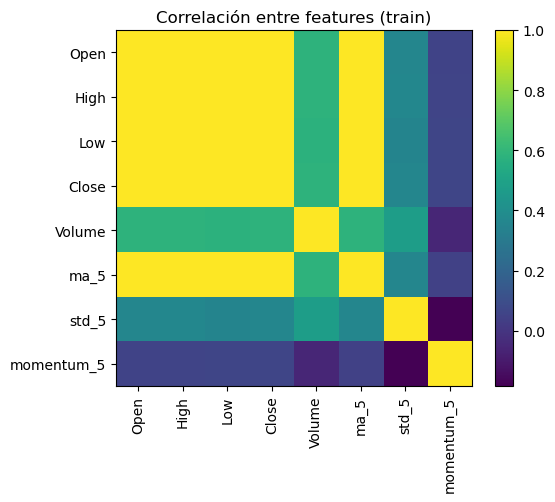

In [13]:

Xtr = X.iloc[:train_size].copy()

# 1) Descriptivo compacto
desc = Xtr.describe(percentiles=[.05,.5,.95]).T.round(3)
display(desc)

# 2) Correlación feature vs target Close (t+1), ordenada
target_close_tr = Ys['Close'].iloc[:train_size]
corr_target = (
    Xtr.assign(target_close_t1=target_close_tr)
       .corr()['target_close_t1']
       .drop('target_close_t1')
       .sort_values(ascending=False)
       .round(3)
)
display(corr_target.to_frame('corr_vs_Close_t+1').head(10))

# 3) Matriz de correlación entre features (heatmap simple con matplotlib)
corr_mat = Xtr.corr().values
labels = Xtr.columns.tolist()

plt.figure(figsize=(6,5))
plt.imshow(corr_mat, interpolation='nearest')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.title('Correlación entre features (train)')
plt.tight_layout()
plt.show()


## 5.3.7 Selección de variables con MI (promedio sobre objetivos, solo train) 

,MI_promedio
Close,4.789
High,3.994
Low,3.963
Open,3.601
ma_5,3.562
Volume,1.184
std_5,0.430
momentum_5,0.207


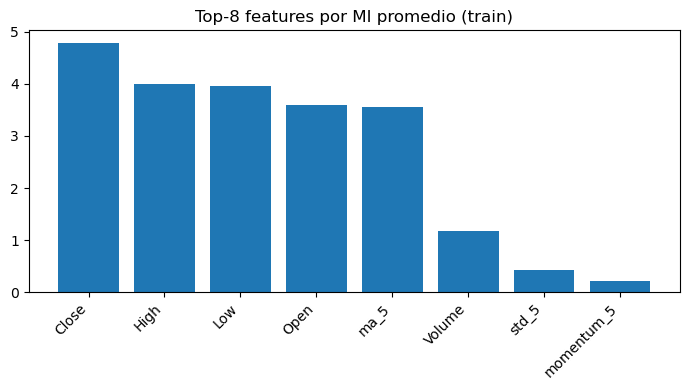

In [14]:

scores_avg = pd.Series(0.0, index=X.columns, dtype='float64')
for obj, y in Ys.items():
    y_tr = y.iloc[:train_size].values
    sel = SelectKBest(mutual_info_regression, k='all')
    sel.fit(X.iloc[:train_size].values, y_tr)
    scores_avg += pd.Series(sel.scores_, index=X.columns).fillna(0.0)

scores_avg /= len(Ys)
mi_rank = scores_avg.sort_values(ascending=False).round(3)
display(mi_rank.to_frame('MI_promedio'))

# Top-k y gráfico de barras (1 figura, sin estilos de color específicos)
k = min(10, len(mi_rank))
topk = mi_rank.head(k)

plt.figure(figsize=(7,4))
plt.bar(range(len(topk)), topk.values)
plt.xticks(range(len(topk)), topk.index, rotation=45, ha='right')
plt.title(f'Top-{k} features por MI promedio (train)')
plt.tight_layout()
plt.show()


# 5.4 Ejecución de experimentos y exportación

## 5.4.1 Entrenamiento de modelos tradicionales

In [15]:

result_rows = []


for objetivo, y in Ys.items():
    y_train = y.iloc[:train_size].values
    y_test  = y.iloc[train_size:].values

    for modelo, cfgs in CONFIGS_TRAD.items():
        for tipo, hp in cfgs:
 
            if modelo == "LinearRegression":
                est = LinearRegression(**hp)
            elif modelo == "Ridge":
                est = Ridge(**hp)
            elif modelo == "Lasso":
                est = Lasso(**hp)
            elif modelo == "BayesianRidge":
                est = BayesianRidge(**hp)
            elif modelo == "DecisionTree":
                est = DecisionTreeRegressor(**hp)
            elif modelo == "RandomForest":
                est = RandomForestRegressor(**hp)
            elif modelo == "HistGradientBoosting":
                est = HistGradientBoostingRegressor(**hp)
            elif modelo == "XGBoost":
                est = XGBRegressor(**hp)
            else:
                raise ValueError(f"Modelo no reconocido: {modelo}")

            pipe = Pipeline([('scaler', StandardScaler()), ('model', est)])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            result_rows.append(row_result(objetivo, modelo, tipo, hp, y_test, y_pred))



## 5.4.2 Entrenamiento de redes neuronales

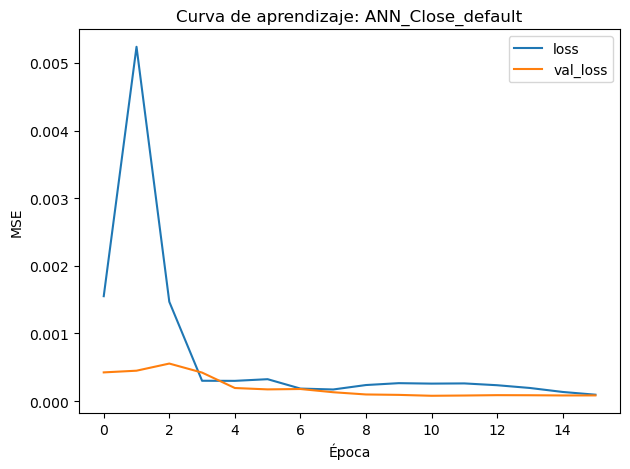

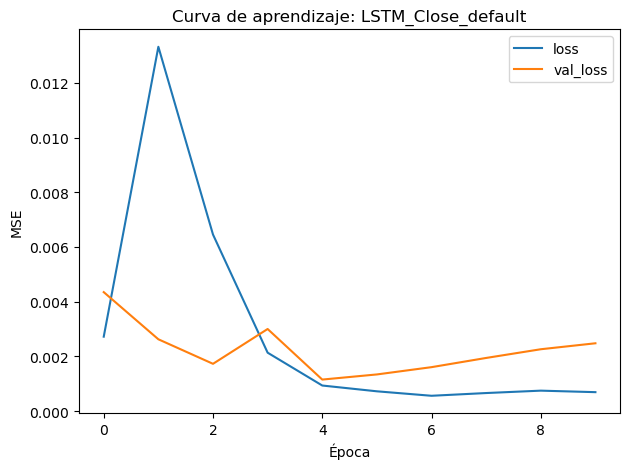

In [16]:

def fit_predict_nn_with_history_plot(model, Xtr, ytr, Xte, epochs=40, batch=64, verbose=0, tag=""):
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.compile(optimizer=Adam(), loss="mse")
    hist = model.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch,
        verbose=verbose,
        callbacks=[es],
        shuffle=False
    ).history
    yhat = model.predict(Xte, verbose=0).flatten()

    # Mostrar curva en notebook (una figura por modelo)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(hist['loss'], label='loss')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='val_loss')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.title(f'Curva de aprendizaje: {tag}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return yhat, hist



# Escalamos X una sola vez
scaler_X_nn = MinMaxScaler()
X_train_nn = scaler_X_nn.fit_transform(X_train.values)  # fit SOLO con train
X_test_nn  = scaler_X_nn.transform(X_test.values)       # transform test


# Secuencial: (samples, timesteps, features) = (n, n_features, 1)
X_train_seq = X_train_nn.reshape((X_train_nn.shape[0], X_train_nn.shape[1], 1))
X_test_seq  = X_test_nn.reshape((X_test_nn.shape[0],  X_test_nn.shape[1],  1))

for objetivo, y in Ys.items():
    # Escalamos y por objetivo para entrenar, pero las métricas serán en escala original
    scaler_y = MinMaxScaler()
    y_train_nn = scaler_y.fit_transform(y.iloc[:train_size].values.reshape(-1,1)).ravel()
    y_test_nn  = scaler_y.transform(y.iloc[train_size:].values.reshape(-1,1)).ravel()
    y_test_orig = y.iloc[train_size:].values  # métricas en escala original


    # ANN (2D)
    for tipo, hp in CONFIGS_NN["ANN"]:
        model = build_ann(X_train_nn.shape[1], hp)
        if (objetivo == "Close") and (tipo == "default"):
            yhat_scaled, _ = fit_predict_nn_with_history_plot(
                model, X_train_nn, y_train_nn, X_test_nn,
                epochs=hp.get("epochs",40), batch=hp.get("batch",64),
                tag="ANN_Close_default"
            )
        else:
            yhat_scaled = fit_predict_nn(
                model, X_train_nn, y_train_nn, X_test_nn,
                epochs=hp.get("epochs",40), batch=hp.get("batch",64)
            )
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "ANN", tipo, hp, y_test_orig, yhat))



    # SimpleRNN
    for tipo, hp in CONFIGS_NN["SimpleRNN"]:
        model = build_rnn(SimpleRNN, X_train_seq.shape[1], 1, hp)
        yhat_scaled = fit_predict_nn(model, X_train_seq, y_train_nn, X_test_seq,
                                     epochs=hp.get("epochs",40), batch=hp.get("batch",64))
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "SimpleRNN", tipo, hp, y_test_orig, yhat))

    # LSTM (secuencial)
    for tipo, hp in CONFIGS_NN["LSTM"]:
        model = build_rnn(LSTM, X_train_seq.shape[1], 1, hp)
        if (objetivo == "Close") and (tipo == "default"):
            yhat_scaled, _ = fit_predict_nn_with_history_plot(
                model, X_train_seq, y_train_nn, X_test_seq,
                epochs=hp.get("epochs",40), batch=hp.get("batch",64),
                tag="LSTM_Close_default"
            )
        else:
            yhat_scaled = fit_predict_nn(
                model, X_train_seq, y_train_nn, X_test_seq,
                epochs=hp.get("epochs",40), batch=hp.get("batch",64)
            )
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "LSTM", tipo, hp, y_test_orig, yhat))



    # GRU
    for tipo, hp in CONFIGS_NN["GRU"]:
        model = build_rnn(GRU, X_train_seq.shape[1], 1, hp)
        yhat_scaled = fit_predict_nn(model, X_train_seq, y_train_nn, X_test_seq,
                                     epochs=hp.get("epochs",40), batch=hp.get("batch",64))
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "GRU", tipo, hp, y_test_orig, yhat))

    # BiLSTM
    for tipo, hp in CONFIGS_NN["BiLSTM"]:
        model = build_bilstm(X_train_seq.shape[1], 1, hp)
        yhat_scaled = fit_predict_nn(model, X_train_seq, y_train_nn, X_test_seq,
                                     epochs=hp.get("epochs",40), batch=hp.get("batch",64))
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "BiLSTM", tipo, hp, y_test_orig, yhat))

    # CNN+LSTM
    for tipo, hp in CONFIGS_NN["CNN+LSTM"]:
        model = build_cnn_lstm(X_train_seq.shape[1], 1, hp)
        yhat_scaled = fit_predict_nn(model, X_train_seq, y_train_nn, X_test_seq,
                                     epochs=hp.get("epochs",40), batch=hp.get("batch",64))
        yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).flatten()
        result_rows.append(row_result(objetivo, "CNN+LSTM", tipo, hp, y_test_orig, yhat))
# === FIN 3.3.2 ===


## 5.4.3 Consolidación y exportación de resultados

In [17]:

# ---------- DataFrames y CSV ----------
df_intra = pd.DataFrame(result_rows)

# Mejor por (objetivo, modelo) según RMSE -> inter-modelos
df_inter = (df_intra.sort_values(["objetivo","modelo","rmse"], ascending=[True,True,True])
                   .groupby(["objetivo","modelo"], as_index=False).head(1)
                   .reset_index(drop=True))

# Guardar CSV con columnas exactas
outdir = "resultados_finales"
os.makedirs(outdir, exist_ok=True)
cols = ["objetivo","modelo","mae","mse","rmse","r2","tipo","hiperparametro"]

df_intra[cols].to_csv(f"{outdir}/comparacion_intramodelo_x3.csv", index=False)
df_inter[cols].to_csv(f"{outdir}/comparacion_intermodelos_mejor_por_modelo.csv", index=False)

print("CSV generados en:", outdir)
display(df_intra[cols].head(12))
display(df_inter[cols].head(12))

CSV generados en: resultados_finales


,objetivo,modelo,mae,mse,rmse,r2,tipo,hiperparametro
0,Open,LinearRegression,13.428518,4.131060e+02,20.325010,0.999510,Tradicional,default
1,Open,LinearRegression,1155.957503,1.336650e+06,1156.135976,-0.586830,Tradicional,ajustada1
2,Open,LinearRegression,13.432918,4.128769e+02,20.319373,0.999510,Tradicional,ajustada2
3,Open,Ridge,14.368628,4.459922e+02,21.118527,0.999471,Tradicional,default
4,Open,Ridge,13.419801,4.073858e+02,20.183801,0.999516,Tradicional,ajustada1
5,Open,Ridge,17.078421,5.950463e+02,24.393571,0.999294,Tradicional,ajustada2
6,Open,Lasso,15.498154,4.746735e+02,21.787002,0.999436,Tradicional,default
7,Open,Lasso,15.879219,5.395553e+02,23.228329,0.999359,Tradicional,ajustada1
8,Open,Lasso,15.120274,4.943739e+02,22.234519,0.999413,Tradicional,ajustada2
9,Open,BayesianRidge,13.428387,4.130942e+02,20.324720,0.999510,Tradicional,default


,objetivo,modelo,mae,mse,rmse,r2,tipo,hiperparametro
0,Close,ANN,81.878693,1.010878e+04,100.542416,0.988007,Red Neuronal,default
1,Close,BayesianRidge,30.187087,1.866749e+03,43.205889,0.997785,Tradicional,ajustada2
2,Close,BiLSTM,366.462128,2.343656e+05,484.113187,0.721940,Red Neuronal,ajustada2
3,Close,CNN+LSTM,358.289337,2.091932e+05,457.376401,0.751805,Red Neuronal,ajustada2
4,Close,DecisionTree,1172.820866,2.199283e+06,1482.997849,-1.609314,Tradicional,ajustada2
5,Close,GRU,270.147644,1.465481e+05,382.816046,0.826130,Red Neuronal,ajustada1
6,Close,HistGradientBoosting,1204.532317,2.279585e+06,1509.829407,-1.704588,Tradicional,ajustada2
7,Close,LSTM,435.017792,4.026560e+05,634.551810,0.522273,Red Neuronal,ajustada2
8,Close,Lasso,30.223556,1.858206e+03,43.106915,0.997795,Tradicional,ajustada2
9,Close,LinearRegression,30.186010,1.867364e+03,43.213002,0.997784,Tradicional,default
